# CAMD novel inorganic crystal structures dataset

This notebook ingests the dataset associated with [Novel inorganic crystal structures predicted using autonomous simulation agents](https://doi.org/10.1038/s41597-022-01438-8) by Ye *et al.*., which is archived on [Figshare](https://doi.org/10.6084/m9.figshare.19601956.v1), with the aim of creating an [OPTIMADE API](https://optimade.org) for the data.

In [1]:
def download_from_figshare(doi, data_dir=None):
    import requests
    import tqdm
    import json
    import os
    import hashlib
    from pathlib import Path

    chunk_size = 1024**2
    figshare_api_url = "https://api.figshare.com/v2/"

    response = requests.get(f"{figshare_api_url}/articles?doi={doi}")
    if response.status_code != 200:
        raise RuntimeError(f"Bad response: {response.content}")
    response = response.json()
    article_id = response[0]["id"]

    response = requests.get(f"{figshare_api_url}/articles/{article_id}")
    if response.status_code != 200:
        raise RuntimeError(f"Bad response: {response.content}")
    response = response.json()

    data_dir = data_dir or "."
    article_dir = Path(data_dir) / f"figshare_{article_id}"
    if not article_dir.exists():
        os.makedirs(article_dir)

    with open(article_dir / "metadata.json", "w") as f:
        json.dump(response, f)

    filenames = []
    file_ids = []

    for files in response["files"]:
        download_url = files["download_url"]
        local_path = Path(data_dir) / f"figshare_{article_id}" / str(files["id"]) / files["name"]
        if local_path.exists():
            with open(local_path, "rb") as f:
                md5 = hashlib.md5(f.read()).hexdigest()
            if md5 != files["supplied_md5"]:
                print(f"Downloaded file {local_path} ({md5!r}) does not match MD5 supplied by figshare ({files['supplied_md5']!r}), will move")
                local_path.replace(Path(str(local_path) + ".old"))
            else:
                print(f"{local_path} already exists locally ({md5!r}), not re-downlaoding...")
                filenames.append(local_path)
                file_ids.append(files["id"])
                continue

        with requests.get(download_url, stream=True) as file_stream:
            print(f"Downloading file {files['name']!r} with size {files['size'] // 1024**2} MB")
            with open(local_path, "wb") as f:
                for chunk in tqdm.tqdm(file_stream.iter_content(chunk_size=chunk_size), total=int(files['size']) // chunk_size, unit=" MB"):
                    f.write(chunk)

        filenames.append(local_path)
        file_ids.append(files["id"])

    return (filenames, file_ids, article_id, article_dir)


def extract_files(files):
    import tarfile
    for f in files:
        if str(f).endswith(".tar.gz"):
            with tarfile.open(f, "r:gz") as tar:
                tar.extractall(f.parent)

In [2]:
# Download dataset
camd_doi = "https://doi.org/10.6084/m9.figshare.19601956.v1"
files, file_ids, article_id, article_dir = download_from_figshare(camd_doi)

figshare_19601956/34818031/camd2022.tar.gz already exists locally ('6433ad2ca4b699f6c409fff4c5469255'), not re-downlaoding...


In [3]:
structure_file = f"figshare_{article_id}/{file_ids[0]}/files/camd_data_to_release_wofeatures.json"

In [4]:
import json
with open(structure_file, "r") as f:
    structure_data = json.load(f)

In [24]:
def pmg_structure_to_optimade_dict(s, object_id=None):
    import re
    import math
    from optimade.models import StructureResourceAttributes
    from optimade.models.utils import anonymous_element_generator
    from bson.objectid import ObjectId

    attributes = {}
    attributes["cartesian_site_positions"] = s.lattice.get_cartesian_coords(s.frac_coords).tolist()
    attributes["fractional_site_positions"] = s.frac_coords.tolist()
    attributes["species_at_sites"] = [_.symbol for _ in s.species]
    attributes["species"] = [{"name": _.symbol, "chemical_symbols": [_.symbol], "concentration": [1]} for _ in set(s.composition.elements)]
    attributes["dimension_types"] = [1, 1, 1]
    attributes["nperiodic_dimensions"] = 3
    attributes["nelements"] = len(s.composition.elements)
    if object_id:
        attributes["last_modified"] = ObjectId(object_id).generation_time
        attributes["immutable_id"] = str(object_id)
    else:
        attributes["last_modified"] = None
        attributes["immutable_id"] = None
    attributes["chemical_formula_descriptive"] = None
    attributes["chemical_formula_anonymous"] = "".join(["".join(x) for x in zip(anonymous_element_generator(), reversed(re.split("[A-Z]", s.composition.anonymized_formula)[1:]))])
    attributes["elements"] = sorted([_.symbol for _ in s.composition.elements])
    gcd = math.gcd(*[int(_) for _ in s.composition.to_reduced_dict.values()])
    attributes["chemical_formula_reduced"] = "".join(_ + f"{int(s.composition.to_reduced_dict[_]) // gcd if s.composition.to_reduced_dict[_] // gcd > 1 else ''}" for _ in attributes["elements"])
    attributes["elements_ratios"] = [s.composition.get_atomic_fraction(e) for e in attributes["elements"]]
    attributes["nsites"] = len(attributes["species_at_sites"])
    attributes["lattice_vectors"] = s.lattice.matrix.tolist()
    attributes["structure_features"] = []
    return StructureResourceAttributes(**attributes)
    
def camd_entry_to_optimade_model(entry):
    from pymatgen.core import Structure
    from optimade.models import StructureResource
    s = entry["structure"]
    object_id = entry["_id"]["oid"]
    attributes = pmg_structure_to_optimade_dict(Structure.from_dict(s), object_id=object_id)
    attributes._odbx_hull_distance = entry["stability"]
    attributes._odbx_formation_energy = entry["delta_e"]
    attributes._odbx_space_group = entry["space_group"]
    _id = entry["data_id"]
    return StructureResource(id=_id, attributes=attributes)


In [39]:
import tqdm
optimade_structure_json = []
for entry in tqdm.tqdm(structure_data):
    structure = camd_entry_to_optimade_model(entry).dict()
    structure.update(structure.pop("attributes"))
    optimade_structure_json.append(structure)

100%|██████████| 131425/131425 [06:58<00:00, 314.27it/s]


In [47]:
import pandas as pd
df = pd.DataFrame(optimade_structure_json)
df.describe()

,nelements,nperiodic_dimensions,nsites,_odbx_hull_distance,_odbx_formation_energy
count,131425.000000,131425.0,131425.000000,131425.000000,131425.000000
mean,2.848271,3.0,13.132692,0.410940,-0.594078
std,0.591254,0.0,9.888142,0.618444,1.066740
min,1.000000,3.0,1.000000,0.000000,-4.720274
25%,3.000000,3.0,7.000000,0.047285,-1.080707
50%,3.000000,3.0,12.000000,0.232201,-0.425085
75%,3.000000,3.0,16.000000,0.471035,-0.017044
max,7.000000,3.0,368.000000,7.732227,4.994135


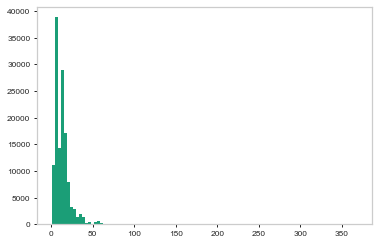

In [42]:
plt.hist(df["nsites"], bins=101);

(array([  462., 30853., 90208.,  8224.,  1448.,   230.]),
 array([1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 6 artists>)

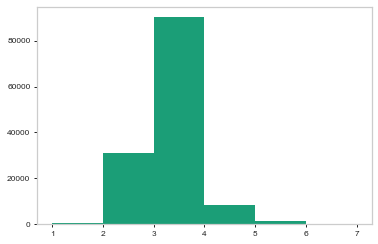

In [46]:
plt.hist(df["nelements"], bins=6)

In [48]:
# Dump with datetime support
from bson.json_util import dumps
with open("camd_optimade.json", "w") as f:
    f.write(dumps(optimade_structure_json))